# hyperparameter-search

![](https://i.imgur.com/ewmZvLw.png)

<div style="background-color: #fff; box-shadow: 0 2px 4px 0 rgba(0,0,0,0.2); padding: 30px; padding-top: 24px; margin: 0px 40px">
This Jupyter notebook is the code compliment to the blog post <b><a href="https://spell.run/blog/an-introduction-to-hyperparameter-search-with-cifar10-Xo8_6BMAACEAkwVs">An introduction to hyperparameter search with CIFAR10</a></b>.
</div>

<br/>

## prerequisites

You will need:
* An account on [Spell for Teams](https://spell.run/pricing) (hyperparameter search is not currently available in the free Spell Community product).
* To have the `keras` and `spell` Python packages installed in your local environment. Alternatively, you can launch this notebook from a Spell workspace by running the following CLI command (requires having the `spell` package installed):

```python
spell jupyter \
    --lab \
    --github-url https://github.com/spellrun/spell-examples.git \
    hyper-demo-workspace
```

## setup

This demo uses a `keras` model trained on CIFAR10. [CIFAR10](https://en.wikipedia.org/wiki/CIFAR-10) is a very popular benchmark dataset for computer vision classification, containing 60,000 32x32 color images in 10 different classes. This example was taken straight from the [Keras examples](https://keras.io/examples/cifar10_cnn/). We've wrapped the model in a training script (using `argparse`) so that it takes the following hyperparameters as input:

* `conv2_filter` &mdash; the size of the convolutional network filters, e.g. the dimensionality of the pixel grids that will be passed over the image.
* `conv2_kernel` &mdash; the number of nodes to include in the convolutional layers.
* `dropout_1`, `dropout_2`, `dropout_3` &mdash; Input convolutional block, hidden convolutional block, and output dropout values, respectively.
* `dense_layer` &mdash; the number of nodes to include in the dense output layer.

If you are not familiar with `argparse` check out `basic.py`, also in this repo folder, for an extremely minimal, bare-bones example of how it works. It boils down to the following:

```python
# create an argument parser and attach user-settable arguments to it
parser = argparse.ArgumentParser()
parser.add_argument('--epochs', type=int, dest='epochs', default=50)

# fetch those arguments; in this case args will be a dict containing a epochs key if the script
# runner provided an epochs value, and 50 if it didn't.
args = parser.parse_args()
```

In [1]:
%%writefile cifar10_cnn.py
'''
This example is modified from https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py

#Train a simple deep CNN on the CIFAR10 small images dataset.

It gets to 75% validation accuracy in 25 epochs, and 79% after 50 epochs.
(it's still underfitting at that point, though).
'''

from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--epochs', type=int, dest='epochs', default=50)
parser.add_argument('--learning_rate', type=float, dest='learning_rate', default=0.0001)
parser.add_argument('--conv2_filter', type=int, dest='conv2_filter', default=64)
parser.add_argument('--conv2_kernel', type=int, dest='conv2_kernel', default=3)
parser.add_argument('--dense_layer', type=int, dest='dense_layer', default=512)

parser.add_argument('--dropout_1', type=float, dest='dropout_1', default=0.25)
parser.add_argument('--dropout_2', type=float, dest='dropout_2', default=0.25)
parser.add_argument('--dropout_3', type=float, dest='dropout_3', default=0.5)
args = parser.parse_args()

batch_size = 32
num_classes = 10
epochs = args.epochs
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(args.dropout_1))

model.add(Conv2D(args.conv2_filter, (args.conv2_kernel, args.conv2_kernel), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(args.conv2_filter, (args.conv2_kernel, args.conv2_kernel)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(args.dropout_2))

model.add(Flatten())
model.add(Dense(args.dense_layer))
model.add(Activation('relu'))
model.add(Dropout(args.dropout_3))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=args.learning_rate, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        # NOTE added to fix crash (https://github.com/keras-team/keras/issues/11874)
                        steps_per_epoch=len(x_train) // batch_size,
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        workers=4)

# Save trained model.
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_json = model.to_json()
model_json_path = os.path.join(save_dir, "model.json")
with open(model_json_path, "w") as json_file:
    json_file.write(model_json)
print('Saved model json at %s ' % model_json_path)
model_weights_path = os.path.join(save_dir, model_name)
model.save(model_weights_path)
print('Saved trained model weights at %s ' % model_weights_path)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Writing cifar10_cnn.py


You can verify that this training script works locally by running the following command:

In [2]:
# !python cifar10_cnn.py

The Spell workspace will not log you in by default. If you are running this notebook from inside of a Spell workspace you will need to run the following command, replacing `YOUR_EMAIL` with your Spell email and `YOUR_PASSWORD` with your Spell password:

In [3]:
# !spell login --identity YOUR_EMAIL --password YOUR_PASSWORD

## launching the searches

We are now ready to launch our hyperparameter searches!

Note that the following commands will launch up to 18 simultaneous K80 runs, each of which will take approximately 30 minutes to execute, for a total cost of around 10$ per search in cloud compute costs.

If you are just testing this feature out, try running `spell hyper grid` with a more constrained set of `param` values, or running `spell hyper random` or `spell hyper bayesian` with a smaller `num-runs` value.

### `spell hyper grid`

In [5]:
!spell hyper grid \
    --machine-type K80 \
    --param conv2_filter=16,72,128 \
    --param dense_layer=32,64,128 \
    --param dropout_3=0.2,0.5 \
    --github-url https://github.com/spellrun/spell-examples.git \
    # --github-ref hyper \
    "python hyper/cifar10_cnn.py \
        --epochs 25 \
        --conv2_filter :conv2_filter: \
        --dense_layer :dense_layer: \
        --dropout_3 :dropout_3:"

💫 Casting hyperparameter search #6…
conv2_filter    dense_layer    dropout_3    Run ID
16              32             0.2          184
16              64             0.2          185
16              128            0.2          186
16              32             0.5          187
16              64             0.5          188
16              128            0.5          189
72              32             0.2          190
72              64             0.2          191
72              128            0.2          192
72              32             0.5          193
72              64             0.5          194
72              128            0.5          195
128             32             0.2          196
128             64             0.2          197
128             128            0.2          198
128             32             0.5          199
128             64             0.5          200
128             128            0.5          201


This launches the simplest type of hyperparameter search, a grid search. You specify grid search parameters by passing a comma-separated list of values to test out, e.g. `16,72,128`. A separate run will then be created, scheduled, and executed for every possible combination of the specified hyperparameters.

Notice the use of the special `:hyperparameter:` syntax in the command body. At runtime Spell will plug the `hyperparameter` value set on the `param` flag into the corresponding `:hyperparameter:` value in the command body.

### `spell hyper random`

In [10]:
!spell hyper random \
    --machine-type K80 \
    --param conv2_filter=16:128:linear:int \
    --param dense_layer=32:128:linear:int \
    --param dropout_3=0.2:0.5 \
    --num-runs 18 \
    --github-url https://github.com/spellrun/spell-examples.git \
    # --github-ref hyper \
    "python hyper/cifar10_cnn.py \
        --epochs 25 \
        --conv2_filter :conv2_filter: \
        --dense_layer :dense_layer: \
        --dropout_3 :dropout_3:"

💫 Casting hyperparameter search #10…
conv2_filter    dense_layer    dropout_3    Run ID
60              39             0.488294     250
110             81             0.499862     251
33              40             0.34271      252
117             128            0.223744     253
117             115            0.465318     254
48              75             0.345887     255
58              121            0.292594     256
84              106            0.41578      257
104             107            0.2267       258
94              85             0.421738     259
36              99             0.399534     260
36              50             0.281066     261
30              78             0.270079     262
60              102            0.384012     263
32              115            0.498942     264
128             77             0.281639     265
19              110            0.318054     266
76              67             0.489551     267


This launches a random hyperparameter search. In random hyperparameter search, instead of picking a value from a list, Spell will pick a value from a range of values at random. For example, `conv2_filter` is set to the range `16:128`, so Spell might randomly pick the values `17, 125, 21, 99, 101, ...`.

Random search outperforms grid search in most practical settings. A good rule of thumb is to switch to using random search whenever you are performing hyperparameter search in more than three dimensions.

The new `num-runs` required parameter specified how many times this process should be repeated. In this case I've specified `18` to match the fidelity of the grid search we just ran (which also executed 3 * 3 * 2 = 18 runs).

Note that the `param` flag also supports a few other useful features. The full parameter signature is:

```
NAME=VALUE[,VALUE,VALUE,...] or NAME=MIN:MAX[:linear|log|reverse_log[:int|float]]
```

So instead of passing a range of values, e.g. `16:128`, you can pass a list of them, e.g. `16, 32, 64, 128`. Spell random will then choose these values at random instead of picking from out of the range. Be careful not to overuse this feature, however, as it basically turns your random search back into a grid search.

You can also specifiy the point selection strategy. The default strategy is `linear`, which samples points, well, linearly. But you can use a `log` or `reverse_log` strategy instead.

Finally, you can specify whether you want to pick integers (`int`) or floating point numbers (`float`) out of the range. This is important because for many parameters (for example, how many nodes should each layer have?), only whole numbers make sense. Spell will default to a floating point number, so to pick whole numbers linearly out of a range of values you will need to use the syntax `16:128:linear:int`, as we did here.

### `spell hyper bayesian`

In [5]:
!spell hyper bayesian \
    --machine-type K80 \
    --param conv2_filter=16:128:int \
    --param dense_layer=32:128:int \
    --param dropout_3=0.2:0.5 \
    --num-runs 18 \
    --parallel-runs 3 \
    --metric keras/val_accuracy \
    --metric-agg last \
    --github-url https://github.com/spellrun/spell-examples.git \
    # --github-ref hyper \
    "python hyper/cifar10_cnn.py \
        --epochs 25 \
        --conv2_filter :conv2_filter: \
        --dense_layer :dense_layer: \
        --dropout_3 :dropout_3:"

💫 Casting hyperparameter search #12…
conv2_filter    dense_layer    dropout_3    Run ID
29              107            0.45447      275
62              49             0.252026     276
40              124            0.214014     277


The last type of hyperparameter search that Spell supports is Bayesian search. In Bayesian search a [Bayesian](https://en.wikipedia.org/wiki/Bayesian_probability) selection algorithm is used to bias the search points selected towards those that the algorithm has deemed probable based on the results of prior selections.

This is the most complex type of hyperparameter search, which is why it's also the one with the largest number of parameters.

`parallel-runs` controls how many runs Spell will try to schedule and execute simultaneously. If this value is set to 1, the search will be performed completely sequentially, and each run will have access to the complete prior history of runs with which to make a decision about what values to choose next. If this value were set to 18, equaling the `num-runs`, we'd schedule every run simultaneously, essentially falling back to random search. Every other number in between offers a tradeoff between how much information the model has as its prior and how quickly the search finishes running.

`metric` controls the metric the Bayesian optimization algorithm is attempting to optimize. In this case we have chosen the `keras/val_accuracy`, e.g. the validation accuracy as reported by `keras`, as our target. `keras` registers certain metrics in an automatic way as part of its training process, and Spell is able to use this information to connect to and report these metric values automatically. For other machine learning frameworks or other types of model metrics you will need to use the Spell Python API to register and report your own custom model metrics.

The last new parameter is `metric-agg`. This controls how the metric history is to be "compressed" into a single number that the Bayesian hyperparameter search algorithm will use for determining model fit. In this case we set it to `last`, e.g. to the final accuracy value reported by the model training script. `avg`, `min` (useful if the metric is a loss function), and `max` are also options.

An example of hyperparameter search with custom metrics enables will be the subject of a future notebook. For now refer to the instructions on the [Metrics](https://spell.run/docs/metrics) page in the docs.

## evaluating results

The results of your hyperparameter searches are available from the "Hyperparamater Searches" page in the [web console](https://web.spell.run/aleksey/hyper-searches).

This page provides an overview of the hyperparameter search points as well as three different visualizations of model performance: a line chart, a table, and a facet chart. For more information on this feature and helpful tips for interpretting these plots see the [Hyperparameter searches](https://spell.run/docs/hyper_searches) page in our docs.

In addition to evaluating model performance in-situ on the web you may also want to pull the metrics down to your local machine so that you may visualize them yourself. Here's a quick recipe for doing so using the Python API:

In [4]:
import pandas as pd

In [5]:
import spell.client

# if running in a Spell workspace you will need to log in first for this to work:
# !spell login --identity YOUR_EMAIL --password YOUR_PASSWORD
client = spell.client.from_environment()

# 196 to 202 happens to be the range of run IDs associated with this search which
# we've selected. Replace these  values with the values associated with your own
# hyperparameter search.
metrics = []
for run_id in range(196, 202):
    run = client.runs.get(run_id)
    
    # we return the metrics data as a generator
    metric = run.metrics("keras/val_accuracy")
    
    df = pd.DataFrame(metric, columns=["timestamp", "epoch", "val_accuracy"])
    df['run_id'] = run_id
    metrics.append(df)

metrics = pd.concat(metrics)

In [6]:
metrics

,timestamp,epoch,val_accuracy,run_id
0,2020-04-07 20:21:36.117924+00:00,0,0.3953,196
1,2020-04-07 20:22:29.501385+00:00,1,0.4583,196
2,2020-04-07 20:23:22.638722+00:00,2,0.4972,196
3,2020-04-07 20:24:16.121827+00:00,3,0.5305,196
4,2020-04-07 20:25:11.049345+00:00,4,0.5272,196
...,...,...,...,...
20,2020-04-07 20:39:45.127875+00:00,20,0.7338,201
21,2020-04-07 20:40:37.629362+00:00,21,0.7286,201
22,2020-04-07 20:41:30.147770+00:00,22,0.7309,201
23,2020-04-07 20:42:22.784600+00:00,23,0.7514,201


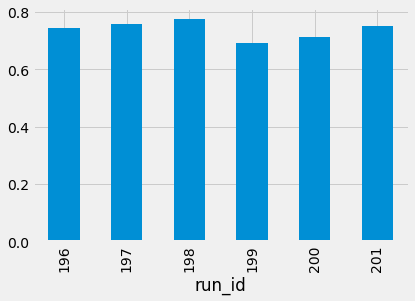

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

metrics.groupby('run_id').val_accuracy.max().plot.bar()